In [1]:
import tensorflow as tf
import gym
import numpy as np
# You must add few lines of code and change all -1s

In [2]:
class Agent:
    def __init__(self, learning_rate):
        # Build the network to predict the correct action
        tf.reset_default_graph()
        input_dimension = 4
        hidden_dimension = 20
        self.input = tf.placeholder(dtype=tf.float32, shape=[1, input_dimension], name='X')
        
        w1 = tf.get_variable('w1',[input_dimension,hidden_dimension],initializer=tf.glorot_normal_initializer())
        b1 = tf.get_variable('b1',[hidden_dimension,],initializer=tf.initializers.zeros())
        hidden_layer = tf.nn.leaky_relu(tf.matmul(self.input,w1) + b1)
        w2 = tf.get_variable('w2',[hidden_dimension,2],initializer=tf.glorot_normal_initializer())
        b2 = tf.get_variable('b2',[2,],initializer=tf.initializers.zeros())
        logits = tf.matmul(hidden_layer,w2) + b2
        self.logits = logits

        # Sample an action according to network's output
        # use tf.multinomial and sample one action from network's output
        self.action = tf.multinomial(tf.log(tf.nn.softmax(logits)), num_samples = 1, name='action')

        # Optimization according to policy gradient algorithm
        
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.one_hot(self.action,depth=2), logits=logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)  # use one of tensorflow optimizers
        
        
        grads_vars = self.optimizer.compute_gradients(
            cross_entropy)  # gradient of current action w.r.t. network's variables
        self.gradients = [grad for grad, var in grads_vars]

        # get rewards from the environment and evaluate rewarded gradients
        #  and feed it to agent and then call train operation
        self.rewarded_grads_placeholders_list = []
        rewarded_grads_and_vars = []
        for grad, var in grads_vars:
            rewarded_grad_placeholder = tf.placeholder(dtype=tf.float32, shape=grad.shape)
            self.rewarded_grads_placeholders_list.append(rewarded_grad_placeholder)
            rewarded_grads_and_vars.append((rewarded_grad_placeholder, var))

        self.train_operation = self.optimizer.apply_gradients(rewarded_grads_and_vars)

        self.saver = tf.train.Saver()

        config = tf.ConfigProto(
            device_count={'GPU': 0}
        )

        self.ses = tf.Session(config=config)
        self.ses.run(tf.global_variables_initializer())

    def get_action_and_gradients(self, obs):
        # compute network's action and gradients given the observations
        action, gradients = self.ses.run([self.action, self.gradients], feed_dict={self.input: np.asarray(obs)[np.newaxis]})
        action = action[0][0]
        return action, gradients

    def train(self, rewarded_gradients):
        feed_dict = {variable: rewarded_gradients[i] for i, variable in enumerate(self.rewarded_grads_placeholders_list)}
        # feed gradients into the placeholder and call train operation
        self.ses.run(self.train_operation, feed_dict = feed_dict)

    def save(self):
        self.saver.save(self.ses, "SavedModel/")

    def load(self):
        self.saver.restore(self.ses, "SavedModel/")

In [71]:
avg_reward = np.zeros((len(discount_factor),epochs))

for df in range(len(discount_factor)):
    
    agent = Agent(learning_rate)
    game = gym.make("CartPole-v0").env

    for epoch in range(epochs):

        epoch_rewards = []
        epoch_gradients = []
        epoch_average_reward = 0
        for episode in range(games_per_epoch):
            obs = game.reset()
            step = 0
            single_episode_rewards = []
            single_episode_gradients = []
            game_over = False
            while not game_over and step < max_steps_per_game:
                step += 1
                #image = game.render(mode='rgb_array') # Call this to render game and show visual
                action, gradients = agent.get_action_and_gradients(obs)
                obs, reward, game_over, info = game.step(action)
                single_episode_rewards.append(reward)
                single_episode_gradients.append(gradients)

            epoch_rewards.append(single_episode_rewards)
            epoch_gradients.append(single_episode_gradients)
            epoch_average_reward += sum(single_episode_rewards)

        epoch_average_reward /= games_per_epoch
        print("Epoch = {}, Average reward = {}".format(epoch, epoch_average_reward))
        
        avg_reward[df,epoch] = epoch_average_reward

        # maximum length of game in one epoch
        length = []
        for reward in epoch_rewards:
            length.append(len(reward))
        max_len = max(length)


        epoch_normalized_rewards = []

        for i in range(len(length)):
            normalized_rewards = []
            for ii in range(length[i]):
                normalized_rewards.append((1-discount_factor[df]**(ii+1))/(1-discount_factor[df])) # geometric sequence
            epoch_normalized_rewards.append(normalized_rewards)

        b = 0 # base line
        for i in range(len(epoch_rewards)):

            b+= (1-discount_factor[df]**(length[i]+1))/(1-discount_factor[df])
        b = b/len(length)

        #normalized_rewards = np.asarray(normalized_rewards) - b 
        for i in range(len(length)):
            epoch_normalized_rewards[i] = np.asarray(epoch_normalized_rewards[i])-b

        dw1 = np.zeros_like(epoch_gradients[0][0][0])
        db1 = np.zeros_like(epoch_gradients[0][0][1])
        dw2 = np.zeros_like(epoch_gradients[0][0][2])
        db2 = np.zeros_like(epoch_gradients[0][0][3])


        N = len(epoch_gradients)
        for e in range(len(epoch_gradients)):
            all_grads = epoch_gradients[e]
            for t in range(len(all_grads)):
                grads = all_grads[t]

                dw1 += epoch_normalized_rewards[e][len(epoch_normalized_rewards[e])-t-1]*grads[0]
                db1 += epoch_normalized_rewards[e][len(epoch_normalized_rewards[e])-t-1]*grads[1]
                dw2 += epoch_normalized_rewards[e][len(epoch_normalized_rewards[e])-t-1]*grads[2]
                db2 += epoch_normalized_rewards[e][len(epoch_normalized_rewards[e])-t-1]*grads[3]
        dw1 = dw1/N
        db1 = db1/N
        dw2 = dw2/N
        db2 = db2/N

        mean_rewarded_gradients = [dw1, db1, dw2, db2]

        agent.train(mean_rewarded_gradients)
    game.close()


Epoch = 0, Average reward = 25.0
Epoch = 1, Average reward = 28.15
Epoch = 2, Average reward = 32.1
Epoch = 3, Average reward = 32.2
Epoch = 4, Average reward = 34.85
Epoch = 5, Average reward = 35.05
Epoch = 6, Average reward = 38.15
Epoch = 7, Average reward = 44.3
Epoch = 8, Average reward = 38.0
Epoch = 9, Average reward = 45.9
Epoch = 10, Average reward = 42.05
Epoch = 11, Average reward = 45.4
Epoch = 12, Average reward = 37.55
Epoch = 13, Average reward = 53.7
Epoch = 14, Average reward = 54.75
Epoch = 15, Average reward = 49.8
Epoch = 16, Average reward = 55.75
Epoch = 17, Average reward = 55.05
Epoch = 18, Average reward = 51.7
Epoch = 19, Average reward = 61.5
Epoch = 20, Average reward = 63.75
Epoch = 21, Average reward = 63.1
Epoch = 22, Average reward = 50.95
Epoch = 23, Average reward = 59.9
Epoch = 24, Average reward = 66.2
Epoch = 25, Average reward = 70.4
Epoch = 26, Average reward = 72.0
Epoch = 27, Average reward = 77.35
Epoch = 28, Average reward = 79.2
Epoch = 29, 

In [72]:
np.save('avg_reward', avg_reward)

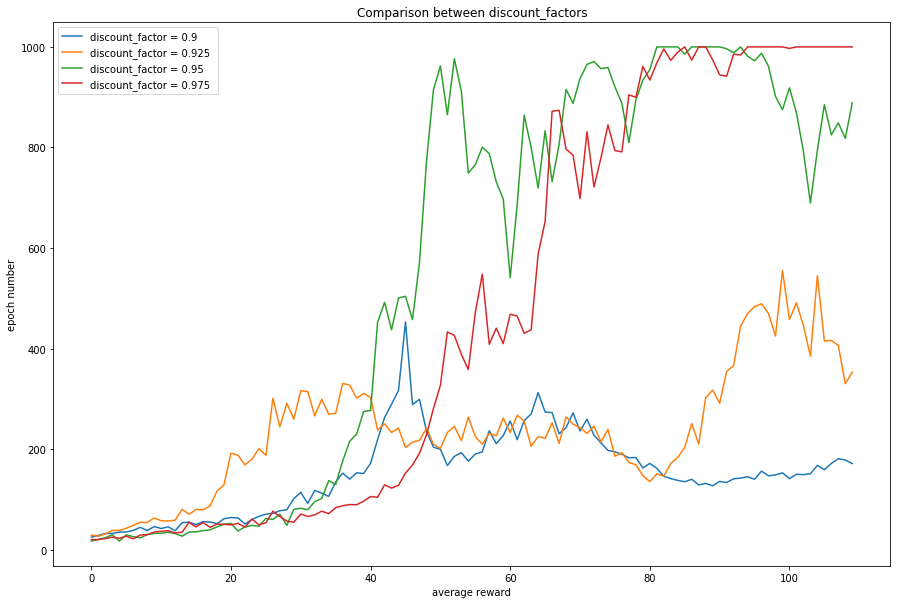

In [75]:
fig = plt.figure(figsize=(15,10))  
plt.plot(range(epochs), avg_reward[0,:], '-', label='discount_factor = 0.9 ')
plt.plot(range(epochs), avg_reward[1,:], '-', label='discount_factor = 0.925 ')
plt.plot(range(epochs), avg_reward[2,:], '-', label='discount_factor = 0.95 ')
plt.plot(range(epochs), avg_reward[3,:], '-', label='discount_factor = 0.975 ')
plt.title('Comparison between discount_factors')
plt.xlabel('average reward')
plt.ylabel('epoch number')


plt.legend(loc='best')
plt.show()

In [34]:
import matplotlib.pyplot as plt

# angle vs. velocity

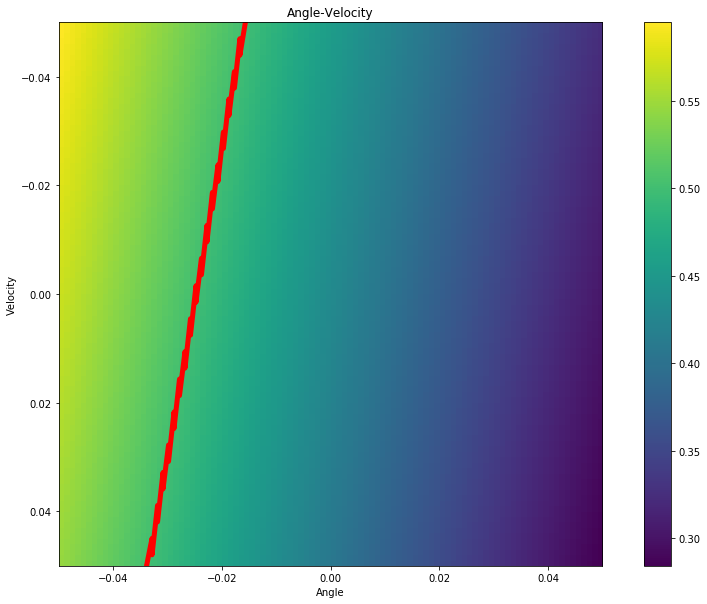

In [57]:
angle_range    = np.linspace(-0.05, 0.05, num = 100)
velocity_range = np.linspace(-0.05, 0.05, num = 100)

x, y = np.meshgrid(angle_range, velocity_range)

ang    = x.reshape(-1)[np.newaxis]
vel    = y.reshape(-1)[np.newaxis]
pos    = np.zeros_like(ang)
angvel = np.zeros_like(ang)

# [Position, Velocity, Angle, Angular Velocity]
Input = np.concatenate((pos,vel,ang,angvel),axis = 0).T

# probabilities
p = tf.nn.softmax(agent.logits)
prob = np.zeros(shape=(Input.shape[0],))
for i in range(Input.shape[0]):
    prob[i] = agent.ses.run(p, feed_dict={agent.input: Input[i,:][np.newaxis]})[0][0]
    
prob = np.reshape(prob, (angle_range.shape[0], velocity_range.shape[0]), order='F')

plt.figure(figsize=(15,10))
plt.imshow(prob.T, extent=[angle_range.min(),angle_range.max(),velocity_range.max(),velocity_range.min()])
plt.colorbar()
x, y = np.where(np.abs(prob-0.5)<1e-3)
plt.plot(angle_range[x],velocity_range[y],'r',linewidth=5)
plt.title("Angle-Velocity")
plt.xlabel("angle")
plt.ylabel("velocity")
plt.show()

# angle vs. angular velocity

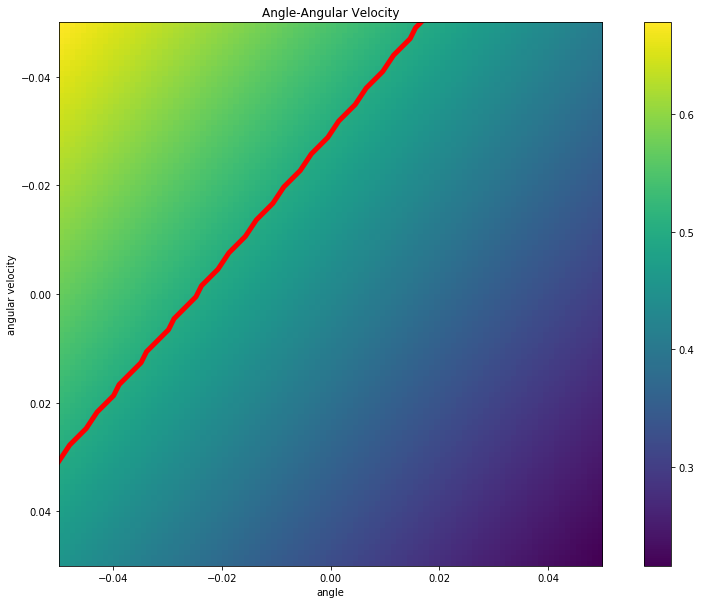

In [60]:
angle_range    = np.linspace(-0.05, 0.05, num = 100)
angvel_range = np.linspace(-0.05, 0.05, num = 100)

x, y = np.meshgrid(angle_range, angvel_range)

ang    = x.reshape(-1)[np.newaxis]
vel    = np.zeros_like(ang)
pos    = np.zeros_like(ang)
angvel = y.reshape(-1)[np.newaxis]

# [Position, Velocity, Angle, Angular Velocity]
Input = np.concatenate((pos,vel,ang,angvel),axis = 0).T

# probabilities
p = tf.nn.softmax(agent.logits)
prob = np.zeros(shape=(Input.shape[0],))
for i in range(Input.shape[0]):
    prob[i] = agent.ses.run(p, feed_dict={agent.input: Input[i,:][np.newaxis]})[0][0]
    
prob = np.reshape(prob, (angle_range.shape[0], angvel_range.shape[0]), order='F')

plt.figure(figsize=(15,10))
plt.imshow(prob.T, extent=[angle_range.min(),angle_range.max(),angvel_range.max(),angvel_range.min()])
plt.colorbar()
x, y = np.where(np.abs(prob-0.5)<1e-3)
plt.plot(angle_range[x],angvel_range[y],'r',linewidth=5)
plt.title("Angle-Angular Velocity")
plt.xlabel("angle")
plt.ylabel("angular velocity")
plt.show()

# velocity vs. angular velocity

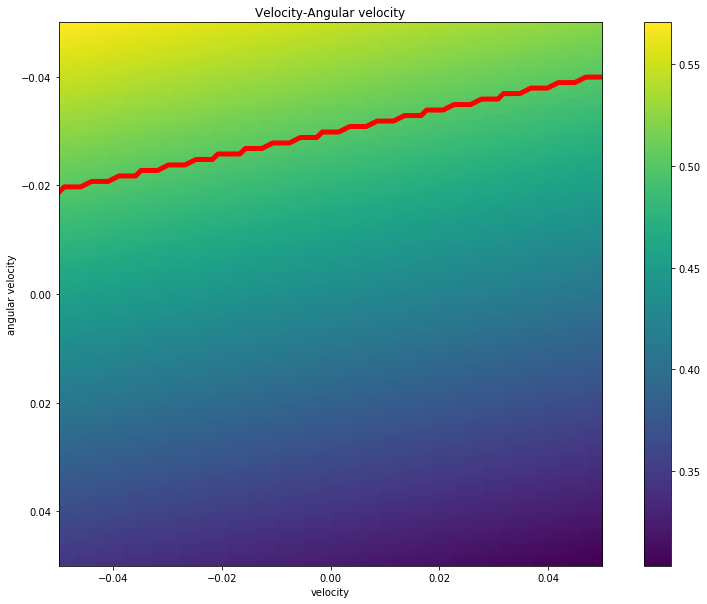

In [61]:
velocity_range    = np.linspace(-0.05, 0.05, num = 100)
angvel_range = np.linspace(-0.05, 0.05, num = 100)

x, y = np.meshgrid(velocity_range, angvel_range)

vel    = x.reshape(-1)[np.newaxis]
ang    = np.zeros_like(vel)
pos    = np.zeros_like(vel)
angvel = y.reshape(-1)[np.newaxis]

# [Position, Velocity, Angle, Angular Velocity]
Input = np.concatenate((pos,vel,ang,angvel),axis = 0).T

# probabilities
p = tf.nn.softmax(agent.logits)
prob = np.zeros(shape=(Input.shape[0],))
for i in range(Input.shape[0]):
    prob[i] = agent.ses.run(p, feed_dict={agent.input: Input[i,:][np.newaxis]})[0][0]
    
prob = np.reshape(prob, (velocity_range.shape[0], angvel_range.shape[0]), order='F')

plt.figure(figsize=(15,10))
plt.imshow(prob.T, extent=[velocity_range.min(),velocity_range.max(),angvel_range.max(),angvel_range.min()])
plt.colorbar()
x, y = np.where(np.abs(prob-0.5)<1e-3)
plt.plot(velocity_range[x],angvel_range[y],'r',linewidth=5)
plt.title("Velocity-Angular velocity")
plt.xlabel("velocity")
plt.ylabel("angular velocity")
plt.show()